In this notebook, we will present how to merge datasets in scVI

In [1]:
import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

'/home/ec2-user/scVI'

In [2]:
use_cuda = True

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.dataset.pbmc import Dataset10X, PbmcDataset
from scvi.inference.posterior import get_bayes_factors
from scvi.models.scanvi import SCANVI



from scvi.inference.posterior import *
from scvi.metrics.clustering import select_indices_evenly, clustering_scores, entropy_batch_mixing
from scipy import sparse
from scvi.models.vae import VAE
from scvi.inference import UnsupervisedTrainer, SemiSupervisedTrainer

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [3]:
from scvi.harmonization.utils_chenling import get_matrix_from_dir,assign_label,run_model
import pandas as pd
from sklearn.cluster import DBSCAN,KMeans,SpectralClustering



In [4]:
# cell_types = np.array(["cd4_t_helper", "regulatory_t", "naive_t", "memory_t", "cytotoxic_t", "naive_cytotoxic",
#                        "b_cells", "cd34", "cd56_nk", "cd14_monocytes"])
# cell_type_name = np.array(["CD4 T cells 2", "CD4 T cells Regulatory", "CD4 T cells Naive", "CD4 Memory T cells", "CD8 T cells", "CD8 T cells Naive",
#                        "B cells", "CD34 cells", "NK cells", "CD14+ Monocytes"])

cell_types = np.array(["regulatory_t", "naive_t", "memory_t",  "naive_cytotoxic"])
cell_type_name = np.array(["CD4 Regulatory", "CD4 Naive", "CD4 Memory", "CD8 Naive"])

datasets = []
for i,cell_type in enumerate(cell_types):
    dataset = Dataset10X(cell_type, save_path='data/')
    dataset.cell_types = np.array([cell_type_name[i]])
    dataset.labels = dataset.labels.astype('int')
    dataset.subsample_genes(dataset.nb_genes)
    dataset.gene_names = dataset.gene_symbols
    datasets += [dataset]

gene_dataset = GeneExpressionDataset.concat_datasets(*datasets, shared_batches=True)


Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15950 genes
Downsampling from 10263 to 10263 cells
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15565 genes
Downsampling from 10479 to 10479 cells
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16169 genes
Downsampling from 10224 to 10224 cells
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15539 genes
Downsampling from 11953 to 11953 cells
Keeping 13540 genes


In [5]:
gene_dataset = GeneExpressionDataset.concat_datasets(*datasets, shared_batches=True)


Keeping 13540 genes


## work with genesets and select nice cells from known markers

In [6]:
to_add = ["CD4", "FOXP3", "TNFRSF18", "IL2RA", "CTLA4", "CD44", "TCF7", "CD8B", "CCR7", "CD69", "PTPRC", "S100A4"]
# TNFRSF18 is supposed to be GITR
# IL2RA for CD25
# could not find CD62L
idx = np.where([x in to_add for x in gene_dataset.gene_names])[0]
gene_dataset.gene_names[idx]

array(['TNFRSF18', 'S100A4', 'PTPRC', 'CD8B', 'CTLA4', 'TCF7', 'FOXP3',
       'IL2RA', 'CD44', 'CD4', 'CD69', 'CCR7'], dtype='<U19')

In [7]:
print(*to_add)

CD4 FOXP3 TNFRSF18 IL2RA CTLA4 CD44 TCF7 CD8B CCR7 CD69 PTPRC S100A4


In [8]:
# NAIVE MARKERS CD62L+ (None) CCR7+ CD25- (IL2RA) CD44- CD69- CD45RO- (PTPRC) 
# REG MARKERS FOXP3+ GITR+ (TNFRSF18) CD25+ (IL2RA) CTLA4+
# MEM MARKERS CD45RO+ (PTPRC) CCR7+ CD44+

In [9]:
# detecting CD4 REG
l_plus = (6, 7)
l_minus = (3,)
s = "geneset: "

for g in l_plus:
    s += gene_dataset.gene_names[idx[g]] + "+ "
for g in l_minus:
    s += gene_dataset.gene_names[idx[g]] + "- "
print(s)


for c in np.unique(gene_dataset.labels.ravel()):
    criterion = gene_dataset.X[gene_dataset.labels.ravel() == c].A[:, idx[l_plus[0]]] > 0
    for g in l_plus[1:]:
        criterion = np.logical_and(criterion, gene_dataset.X[gene_dataset.labels.ravel() == c].A[:, idx[g]] > 0)
    for g in l_minus:
        criterion = np.logical_and(criterion, gene_dataset.X[gene_dataset.labels.ravel() == c].A[:, idx[g]] == 0)
    print("cell-type ", gene_dataset.cell_types[c], " ", np.sum(criterion))

geneset: FOXP3+ IL2RA+ CD8B- 
cell-type  CD4 Memory   15
cell-type  CD4 Naive   1
cell-type  CD8 Naive   0
cell-type  CD4 Regulatory   82


geneset: TNFRSF18+ CTLA4+ FOXP3+ IL2RA+ S100A4- PTPRC- CD8B- 
['CD4 Memory', 'CD4 Regulatory'] [ 8 42]


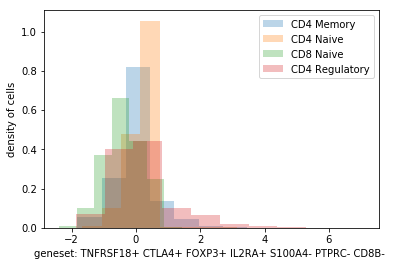

In [10]:
# quantitatively detecting CD4 REG
l_plus = (0, 4, 6, 7)
l_minus = (1, 2, 3)
s = "geneset: "

for g in l_plus:
    s += gene_dataset.gene_names[idx[g]] + "+ "
for g in l_minus:
    s += gene_dataset.gene_names[idx[g]] + "- "
print(s)

expression = gene_dataset.X.A
expression = np.log(1 + 1e4 * expression[:, idx] / np.sum(expression, axis=1)[:, np.newaxis])
expression = expression - np.mean(expression, axis=0)
expression = expression / np.std(expression, axis=0)
expression[np.logical_not(np.isfinite(expression))] = 0
score = 0
score += np.mean(expression[:, l_plus], axis=1)
score += - np.mean(expression[:, l_minus], axis=1)

for c in np.unique(gene_dataset.labels.ravel()):
    plt.hist(score[gene_dataset.labels.ravel() == c], label = gene_dataset.cell_types[c], alpha=0.3, density=True, bins=10)

plt.legend()
# plt.xlim((0, np.max(score)))
plt.xlabel(s)
plt.ylabel("density of cells")

output = np.unique(gene_dataset.labels.ravel()[score.argsort()[-50:][::-1]], return_counts=True)
print([gene_dataset.cell_types[t] for t in output[0]], output[1])

cell_idx = score.argsort()[-50:][::-1]
mask_reg = np.array([i in cell_idx for i in range(gene_dataset.X.shape[0])])
  
plt.show()

geneset: CD8B+ CCR7+ CD4- 
['CD4 Naive', 'CD8 Naive'] [ 2 48]


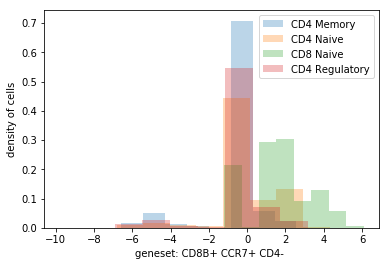

In [11]:
# detecting CD8 naive
l_plus = (3, 11)
l_minus = (9,)
s = "geneset: "

for g in l_plus:
    s += gene_dataset.gene_names[idx[g]] + "+ "
for g in l_minus:
    s += gene_dataset.gene_names[idx[g]] + "- "
print(s)

expression = gene_dataset.X.A
expression = np.log(1 + 1e4 * expression[:, idx] / np.sum(expression, axis=1)[:, np.newaxis])
expression = expression - np.mean(expression, axis=0)
expression = expression / np.std(expression, axis=0)
expression[np.logical_not(np.isfinite(expression))] = 0
score = 0
score += np.sum(expression[:, l_plus], axis=1)
score += - np.sum(expression[:, l_minus], axis=1)

for c in np.unique(gene_dataset.labels.ravel()):
    plt.hist(score[gene_dataset.labels.ravel() == c], label = gene_dataset.cell_types[c], alpha=0.3, density=True, bins=10)
plt.legend()
plt.xlabel(s)
plt.ylabel("density of cells")


output = np.unique(gene_dataset.labels.ravel()[score.argsort()[-50:][::-1]], return_counts=True)
print ([gene_dataset.cell_types[t] for t in output[0]], output[1])

cell_idx = score.argsort()[-50:][::-1]
mask_naive8 = np.array([i in cell_idx for i in range(gene_dataset.X.shape[0])])

plt.show()

geneset: CCR7+ CD4+ S100A4- PTPRC- FOXP3- IL2RA- CD69- 
['CD4 Naive', 'CD4 Regulatory'] [43  7]


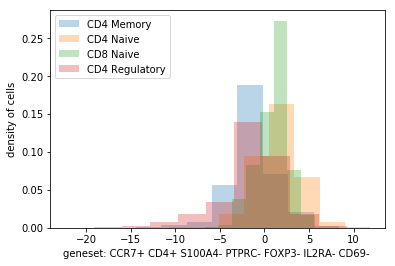

In [12]:
# detecting CD4 naive
l_plus = (11, 9)
l_minus = (1, 2, 6, 7, 10)
s = "geneset: "

for g in l_plus:
    s += gene_dataset.gene_names[idx[g]] + "+ "
for g in l_minus:
    s += gene_dataset.gene_names[idx[g]] + "- "
print(s)

expression = gene_dataset.X.A
expression = np.log(1 + 1e4 * expression[:, idx] / np.sum(expression, axis=1)[:, np.newaxis])
expression = expression - np.mean(expression, axis=0)
expression = expression / np.std(expression, axis=0)
expression[np.logical_not(np.isfinite(expression))] = 0
score = 0
score += np.sum(expression[:, l_plus], axis=1)
score += - np.sum(expression[:, l_minus], axis=1)

for c in np.unique(gene_dataset.labels.ravel()):
    plt.hist(score[gene_dataset.labels.ravel() == c], label = gene_dataset.cell_types[c], alpha=0.3, density=True, bins=10)

plt.legend()
plt.xlabel(s)
plt.ylabel("density of cells")

output = np.unique(gene_dataset.labels.ravel()[score.argsort()[-50:][::-1]], return_counts=True)
print ([gene_dataset.cell_types[t] for t in output[0]], output[1])

cell_idx = score.argsort()[-50:][::-1]
mask_naive4 = np.array([i in cell_idx for i in range(gene_dataset.X.shape[0])])

plt.show()

geneset: S100A4+ IL2RA- FOXP3- TNFRSF18- CCR7- 
['CD4 Memory', 'CD4 Regulatory'] [48  2]


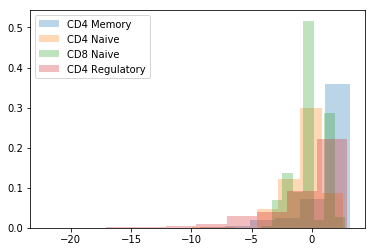

In [13]:
# detecting CD4 MEM
l_plus = (1,)
l_minus = (7, 6, 0, 11)
s = "geneset: "

for g in l_plus:
    s += gene_dataset.gene_names[idx[g]] + "+ "
for g in l_minus:
    s += gene_dataset.gene_names[idx[g]] + "- "
print(s)

expression = gene_dataset.X.A
expression = np.log(1 + 1e4 * expression[:, idx] / np.sum(expression, axis=1)[:, np.newaxis])
expression = expression - np.mean(expression, axis=0)
expression = expression / np.std(expression, axis=0)
expression[np.logical_not(np.isfinite(expression))] = 0
score = 0
score += np.sum(expression[:, l_plus], axis=1)
score += - np.sum(expression[:, l_minus], axis=1)

for c in np.unique(gene_dataset.labels.ravel()):
    plt.hist(score[gene_dataset.labels.ravel() == c], label = gene_dataset.cell_types[c], alpha=0.3, density=True, bins=10)

plt.legend()


output = np.unique(gene_dataset.labels.ravel()[score.argsort()[-50:][::-1]], return_counts=True)
print ([gene_dataset.cell_types[t] for t in output[0]], output[1])

cell_idx = score.argsort()[-50:][::-1]
mask_mem = np.array([i in cell_idx for i in range(gene_dataset.X.shape[0])])

plt.show()

In [14]:
for t in range(idx.shape[0]):
    print("gene ", gene_dataset.gene_names[idx[t]])
    print(np.mean(gene_dataset.X[:, idx[t]].A > 0))
#     for c in np.unique(gene_dataset.labels.ravel()):
#         print("cell-type ", gene_dataset.cell_types[c], 
#               " ", np.sum(gene_dataset.X[gene_dataset.labels.ravel() == c].A[:, idx[t]] > 0))

gene  TNFRSF18
0.03317877862951141
gene  S100A4
0.5907406975931405
gene  PTPRC
0.1831123744728442
gene  CD8B
0.2081362566695403
gene  CTLA4
0.013210932221160791
gene  TCF7
0.17724084904121717
gene  FOXP3
0.017032083692537104
gene  IL2RA
0.02166872480719495
gene  CD44
0.2776159742771267
gene  CD4
0.05452130757939374
gene  CD69
0.1762855611733731
gene  CCR7
0.22852349775157854


gene  TNFRSF18


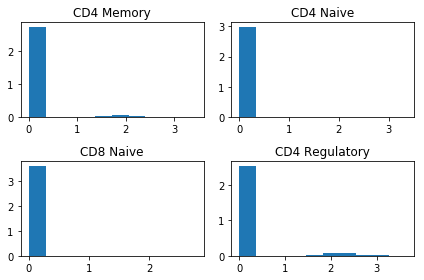

gene  S100A4


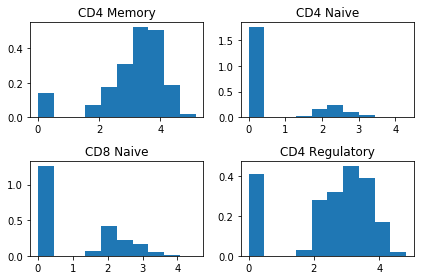

gene  PTPRC


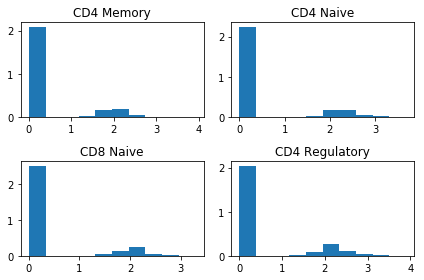

gene  CD8B


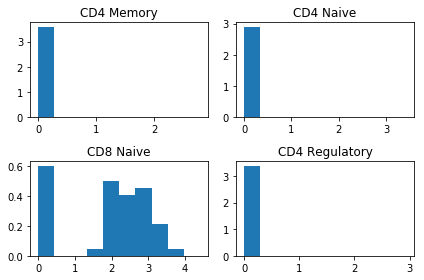

gene  CTLA4


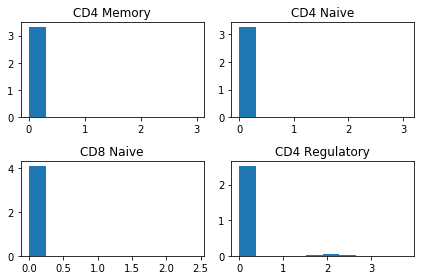

gene  TCF7


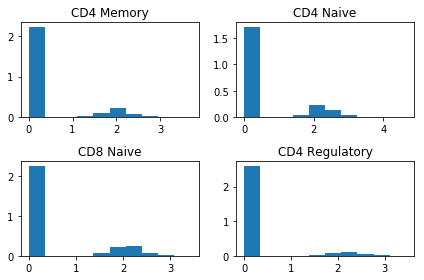

gene  FOXP3


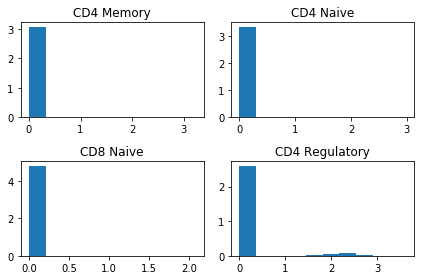

gene  IL2RA


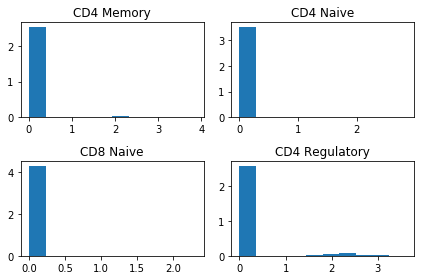

gene  CD44


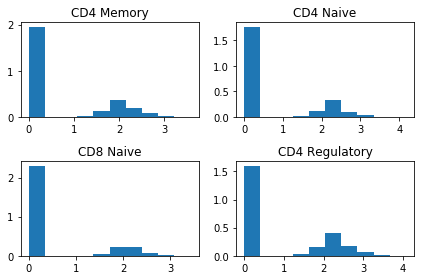

gene  CD4


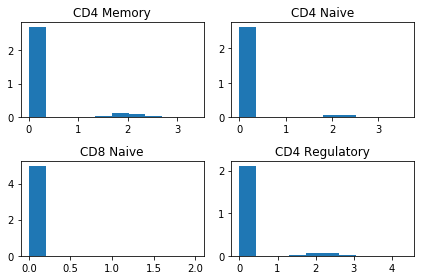

gene  CD69


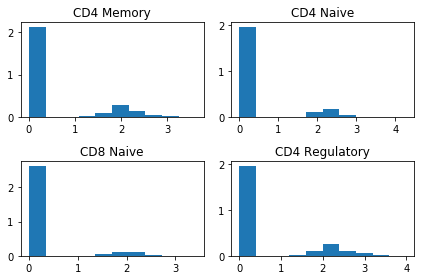

gene  CCR7


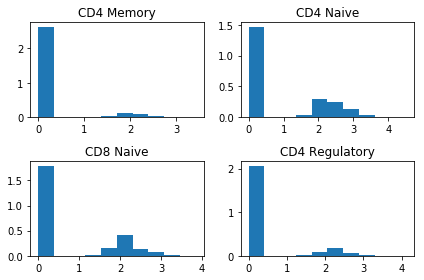

In [15]:
for t in range(idx.shape[0]):
    print("gene ", gene_dataset.gene_names[idx[t]])
    for c in np.unique(gene_dataset.labels.ravel()):
        plt.subplot(221 + c)
        interest = gene_dataset.X[gene_dataset.labels.ravel() == c].A
        interest = np.log(1 + 1e4 * interest[:, idx[t]] / np.sum(interest, axis=1))
        plt.hist(interest, density=True)
        plt.title(gene_dataset.cell_types[c])
    plt.tight_layout()
    plt.show()
        

In [16]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
          n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
# trainer.train(n_epochs=150)
import torch
# torch.save(trainer.model.state_dict(),'../models/Pure-mild-annot.4Kgenes.vae.pkl')
# torch.save(trainer.model.state_dict(),'../models/Pure-mild-annot.1Kgenes.vae.pkl')
# trainer.model.load_state_dict(torch.load('../models/Pure-mild-annot.vae.pkl'))
# trainer.model.eval()
trainer.model.load_state_dict(torch.load('../models/Pure-mild-annot.4Kgenes.vae.pkl'))
trainer.model.eval()


VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (linear_0): Linear(in_features=13540, out_features=128, bias=True)
          (batch_norm_0): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (non_linearity_0): ReLU()
        )
        (Layer 1): Sequential(
          (linear_1): Linear(in_features=128, out_features=128, bias=True)
          (batch_norm_1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (non_linearity_1): ReLU()
          (dropout_1): Dropout(p=0.1)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (linear_0): Linear(in_features=13540, out_features=128, bias=True)
      

In [17]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()

In [18]:
scanvi = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels, n_layers=2,  
                                       classifier_parameters = {'dropout_rate':0.2, 'n_hidden':256, 'n_layers':2})

scanvi.load_state_dict(trainer.model.state_dict(), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, gene_dataset, classification_ratio=100,
                                       n_epochs_classifier=1, lr_classification=5 * 1e-3)

In [19]:
indicator_lab = np.zeros_like(labels)
indicator_lab[mask_mem] = 1
indicator_lab[mask_naive4] = 1
indicator_lab[mask_naive8] = 1
indicator_lab[mask_reg] = 1

In [20]:
trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=(indicator_lab == 1))
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=(indicator_lab == 0))

In [21]:
trainer_scanvi.train(n_epochs=5)

training: 100%|██████████| 5/5 [01:01<00:00, 12.37s/it]


In [22]:
full_scanvi = trainer_scanvi.create_posterior(trainer_scanvi.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent_scanvi, batch_indices, labels = full_scanvi.sequential().get_latent()

In [23]:
from scvi.metrics.clustering import select_indices_evenly
import seaborn as sns

colors = sns.color_palette('tab20')
latent_s = latent_scanvi
label_s = labels
batch_s = batch_indices

from umap import UMAP
latent_u = UMAP(spread=2).fit_transform(latent_s)

## let us look at the UMAP

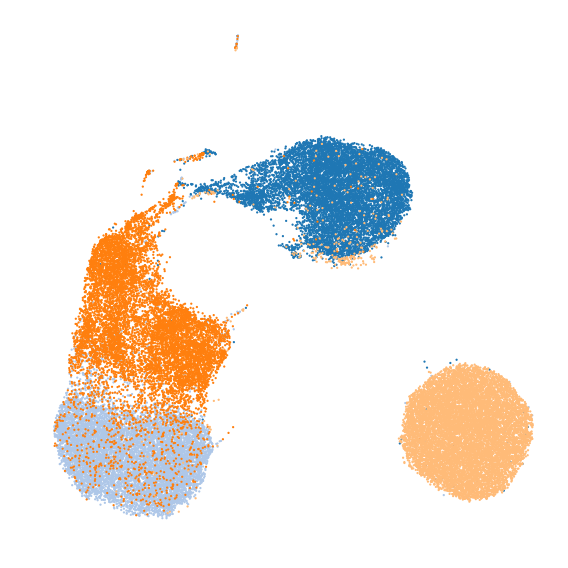

In [24]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(key_order):
    idx = label_s==k
    ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none',s=5)
# plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_annot_origin.pdf", transparency=True)

# the ordering of the masks needs to be changed manually to match the actual order of the cell type labels (which is assigned randomly) 

['CD4 Memory' 'CD4 Naive' 'CD8 Naive' 'CD4 Regulatory']


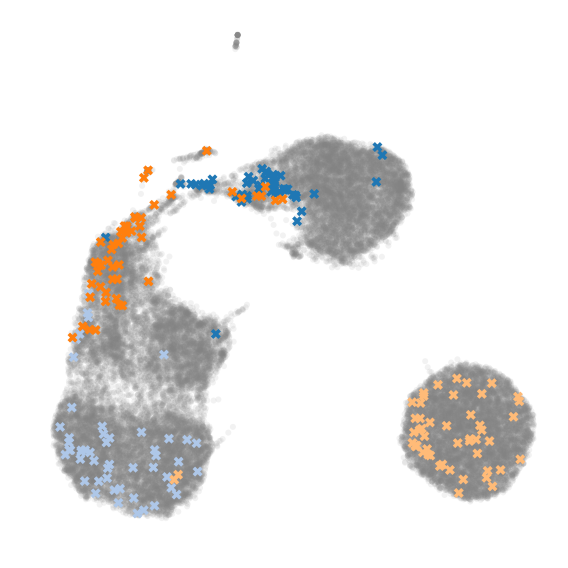

In [25]:
keys = gene_dataset.cell_types
print(keys)
mask = [mask_mem, mask_naive4, mask_reg, mask_naive8]
# mask = [mask_mem, mask_naive8,mask_naive8, mask_reg]
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(latent_u[:, 0], latent_u[:, 1], c="grey", edgecolors='none', alpha=0.1)
for i,x in enumerate(keys[key_order]):
    idx = mask[i] == True
    ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=x,
                   edgecolors='none', s=100, marker="X")
# plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_annot_from_genes.pdf", transparency=True)

In [26]:
all_y_pred = []
for i_batch, tensors in enumerate(full.sequential()):
    sample_batch, _, _, _, _ = tensors
    all_y_pred += [scanvi.classify(sample_batch)]
all_y_pred = np.array(torch.cat(all_y_pred))    

In [27]:
np.mean(all_y_pred.argmax(1) == labels)

0.9216197954285981

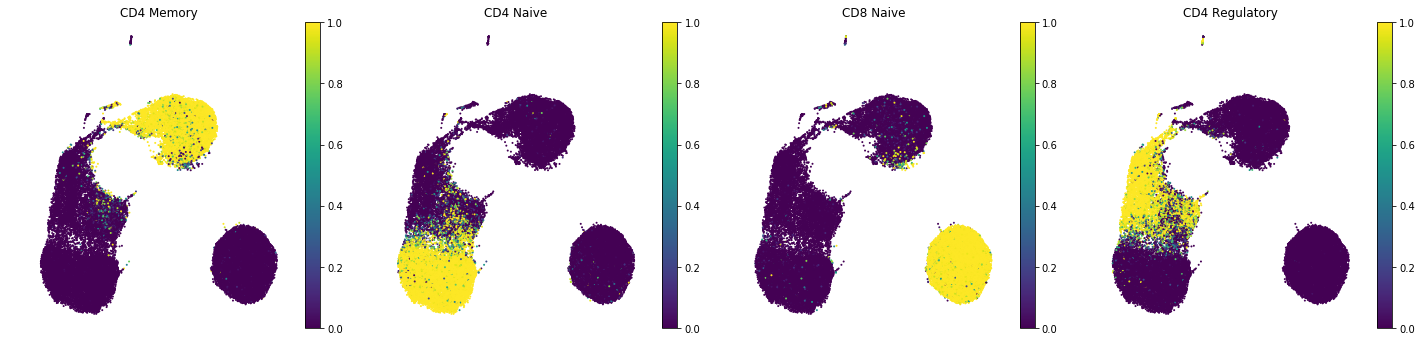

In [28]:
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(141 + i)
    plt.scatter(latent_u[:, 0], latent_u[:, 1], c=all_y_pred[:, i],
                       edgecolors='none', s=4)
    plt.colorbar()
    plt.title(gene_dataset.cell_types[i])
    plt.axis("off")
plt.tight_layout()
plt.savefig("figures/mild_anot.colorbar.pdf", transparency=True)

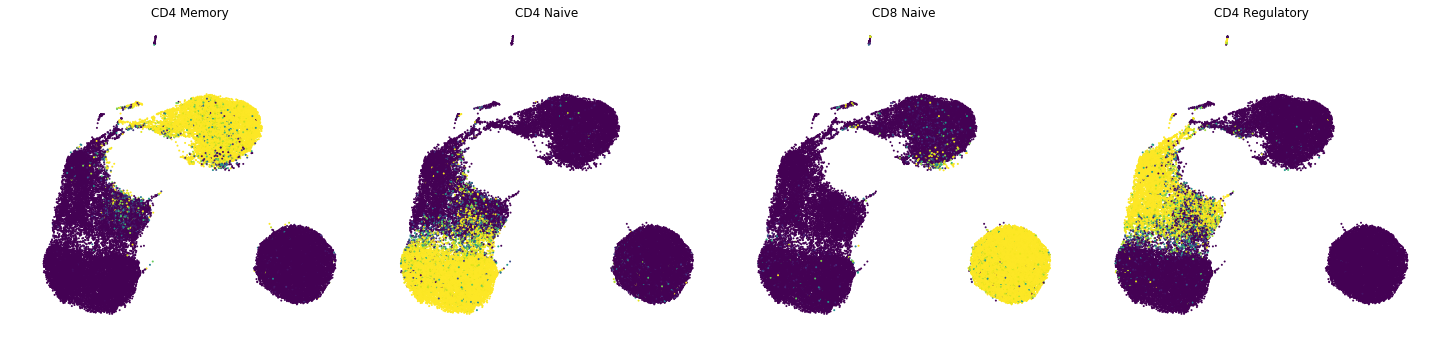

In [29]:
plt.figure(figsize=(20, 5))
for i in range(4):
    plt.subplot(141 + i)
    plt.scatter(latent_u[:, 0], latent_u[:, 1], c=all_y_pred[:, i],
                       edgecolors='none', s=4)
#     plt.colorbar()
    plt.title(gene_dataset.cell_types[i])
    plt.axis("off")
plt.tight_layout()
plt.savefig("figures/mild_anot.pdf", transparency=True)

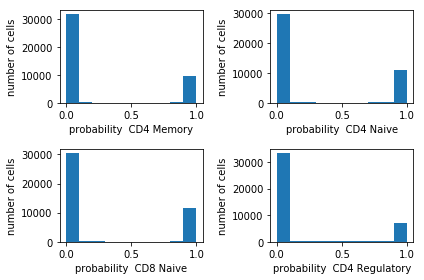

In [30]:
for i in range(4):
    plt.subplot(221 + i)
    plt.hist(all_y_pred[:, i])
    plt.xlabel("probability  "+gene_dataset.cell_types[i])
    plt.ylabel("number of cells")
plt.tight_layout()
plt.show()

### CCA latent

In [31]:
from numpy import genfromtxt
latent_seurat = genfromtxt('../Tcells/Tcells.1.CCA.txt', delimiter=' ')

In [32]:
latent_seurat_u = UMAP(spread=2).fit_transform(latent_seurat)

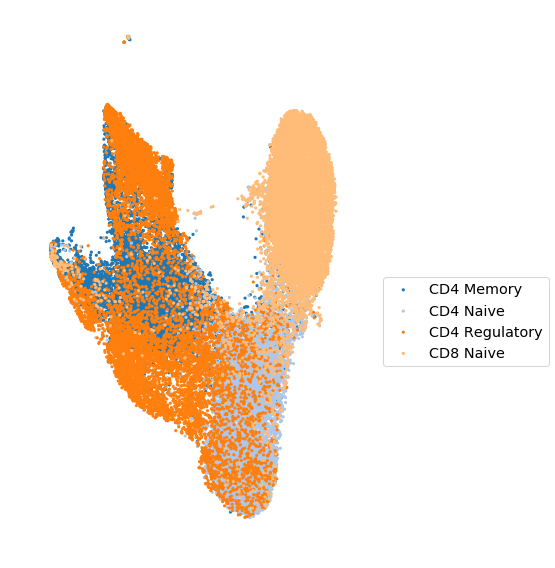

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(key_order):
    idx = label_s==k
    ax.scatter(latent_seurat_u[idx, 0], latent_seurat_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none',s=10)
plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_annot_cca_latent_origin.pdf", transparency=True)

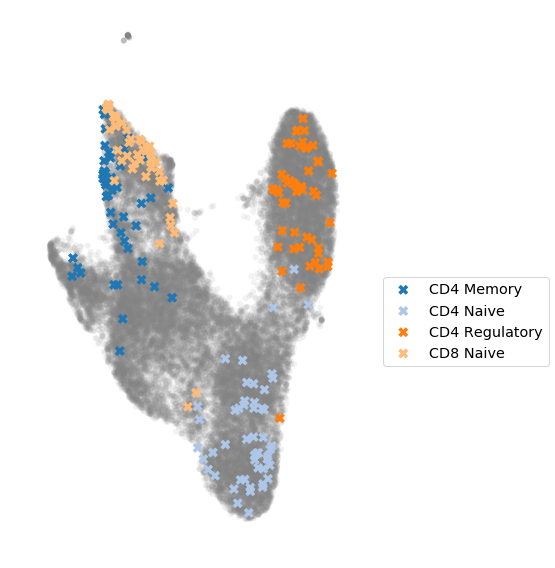

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(latent_seurat_u[:, 0], latent_seurat_u[:, 1], c="grey", edgecolors='none', alpha=0.1)
for i,k in enumerate(key_order):
    idx = mask[k] == True
    ax.scatter(latent_seurat_u[idx, 0], latent_seurat_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none', s=100, marker="X")
plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.show()

In [35]:
latent_scVI_u = UMAP(spread=2).fit_transform(latent)

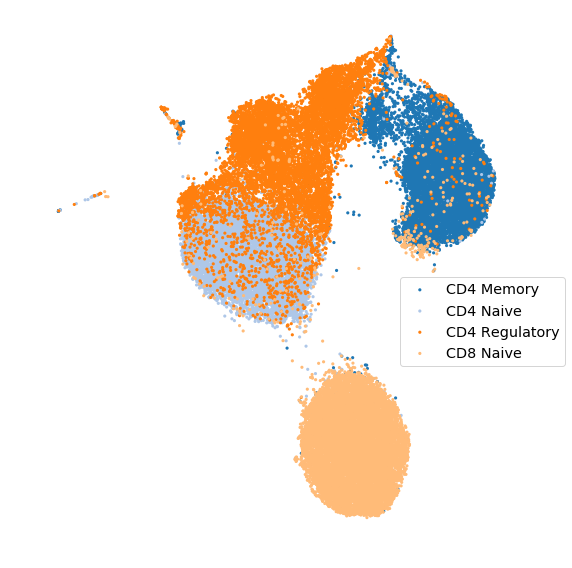

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(key_order):
    idx = label_s==k
    ax.scatter(latent_scVI_u[idx, 0], latent_scVI_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none',s=10)
plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_annot_scVI_origin.pdf", transparency=True)

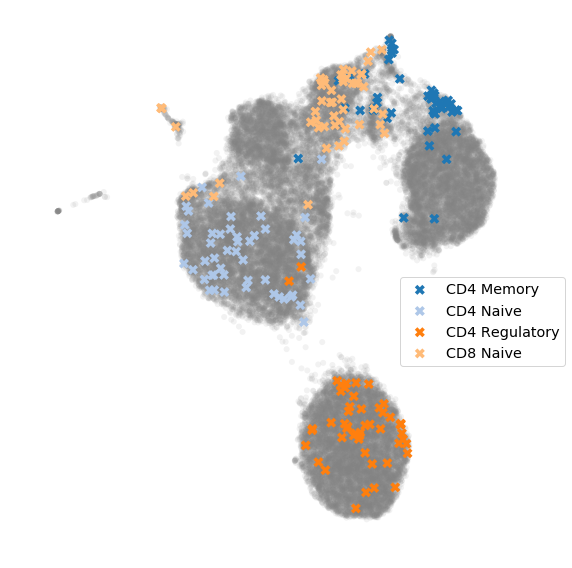

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(latent_scVI_u[:, 0], latent_scVI_u[:, 1], c="grey", edgecolors='none', alpha=0.1)
for i,k in enumerate(key_order):
    idx = mask[k] == True
    ax.scatter(latent_scVI_u[idx, 0], latent_scVI_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none', s=100, marker="X")
plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.show()

In [38]:
from sklearn.neighbors import KNeighborsClassifier
def PartialPrediction(latent,labelled_idx,unlabelled_idx,labels):
        latent_labelled = latent[labelled_idx, :]
        latent_unlabelled = latent[unlabelled_idx, :]
        labels_labelled = labels[labelled_idx]
        labels_unlabelled = labels[unlabelled_idx]
        neigh = KNeighborsClassifier(n_neighbors=10)
        neigh = neigh.fit(latent_labelled, labels_labelled)
        labels_pred = neigh.predict(latent_unlabelled)
        return labels_pred

labelled_idx = trainer_scanvi.labelled_set.indices
unlabelled_idx = trainer_scanvi.unlabelled_set.indices

In [39]:
scvi_pred = PartialPrediction(latent, labelled_idx,unlabelled_idx,gene_dataset.labels.ravel())

In [40]:
seurat_pred = PartialPrediction(latent_seurat, labelled_idx,unlabelled_idx,gene_dataset.labels.ravel())

In [41]:
len(seurat_pred)

42719

In [42]:
np.mean(gene_dataset.labels.ravel()[unlabelled_idx]==seurat_pred)

0.7254617383365716

In [43]:
from copy import deepcopy
seurat_res = deepcopy(gene_dataset.labels.ravel())
seurat_res[unlabelled_idx] = seurat_pred

In [44]:
seurat_pred_s = seurat_res

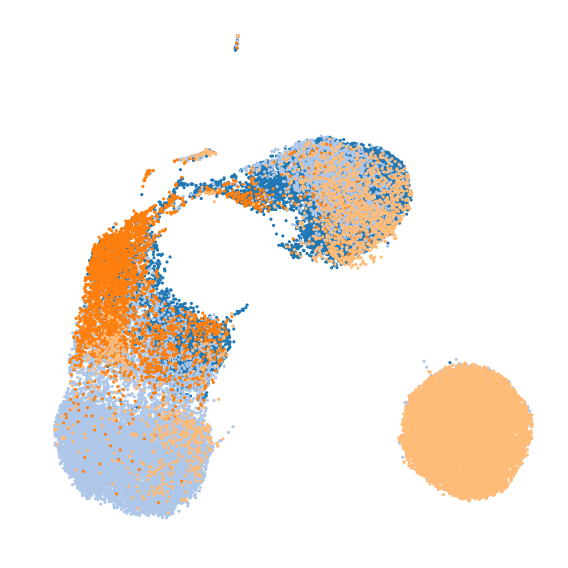

In [45]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(key_order):
    idx = seurat_pred_s==k
    ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none',s=10)
# plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_anot_seuratknn.pdf", transparency=True)

In [46]:
full_scanvi = trainer_scanvi.create_posterior(trainer_scanvi.model, gene_dataset)
y_pred = full_scanvi.compute_predictions()[1]


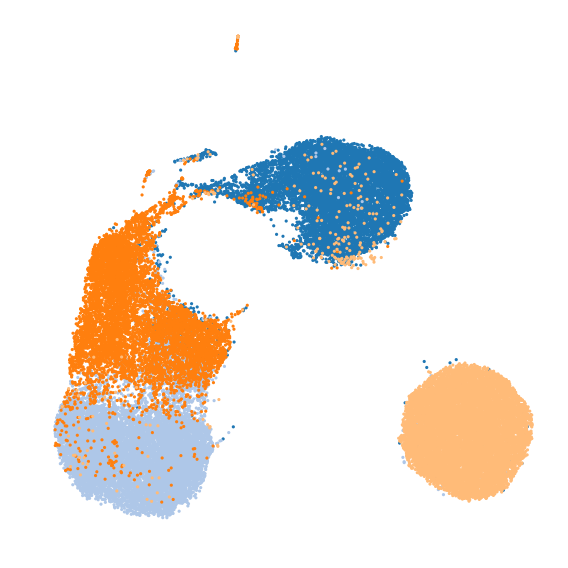

In [47]:
pred_s = y_pred

keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(key_order):
    idx = pred_s==k
    ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none',s=10)
# plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_anot_scanvi.pdf", transparency=True)

In [48]:
np.mean(y_pred[unlabelled_idx]==gene_dataset.labels.ravel()[unlabelled_idx])

0.9212528383155036

In [49]:
def unsupervised_clustering_accuracy(y, y_pred, weighted=False):
    """
    Unsupervised Clustering Accuracy
    """
    assert len(y_pred) == len(y)
    u = np.unique(y)
    n_clusters = len(u)
    mapping = dict(zip(u, range(n_clusters)))
    reward_matrix = np.zeros((n_clusters, n_clusters), dtype=np.int64)
    for y_pred_, y_ in zip(y_pred, y):
        if y_pred_ in u:
            reward_matrix[y_pred_, mapping[y_]] += 1
    cost_matrix = reward_matrix.max() - reward_matrix
    ind = linear_assignment(cost_matrix)
    if weighted is True:
        # columns correspond to true lables and rows correspond to predicted labels
        _, y_norm = np.unique(y, return_counts=True)
        return np.mean([reward_matrix[i, j] / y_norm[j] for i, j in ind])
    else:
        return sum([reward_matrix[i, j] for i, j in ind]) * 1.0 / y_pred.size, ind

In [50]:
n_labels = len(np.unique(gene_dataset.labels))
scvi_KMeans_labels_pred = KMeans(n_labels, n_init=200).fit_predict(latent)
scvi_KMeans_acc = unsupervised_clustering_accuracy(gene_dataset.labels.ravel(), scvi_KMeans_labels_pred, True)

In [51]:
scvi_KMeans_acc

0.7588991780030497

In [52]:
seurat_KMeans_labels_pred = KMeans(n_labels, n_init=200).fit_predict(latent_seurat)
seurat_KMeans_acc = unsupervised_clustering_accuracy(gene_dataset.labels.ravel(), seurat_KMeans_labels_pred, True)

In [53]:
seurat_KMeans_acc

0.7206464335249849

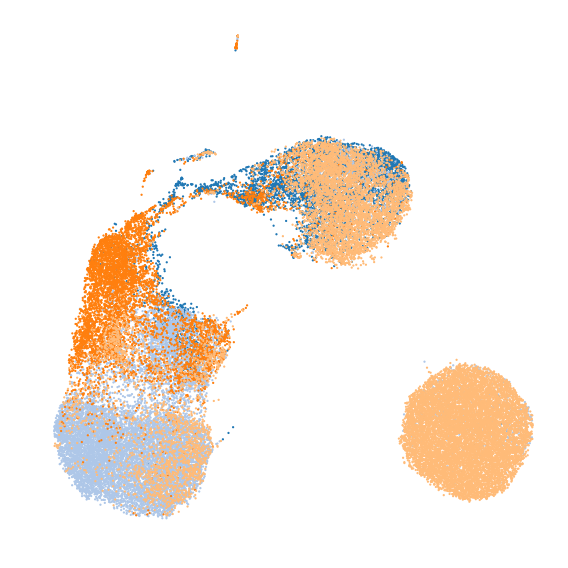

In [54]:
res = deepcopy(gene_dataset.labels.ravel())
res[unlabelled_idx] = scvi_pred

fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(key_order):
    idx = res==k
    ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none',s=5)
# plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_anot_scviKNN.pdf", transparency=True)

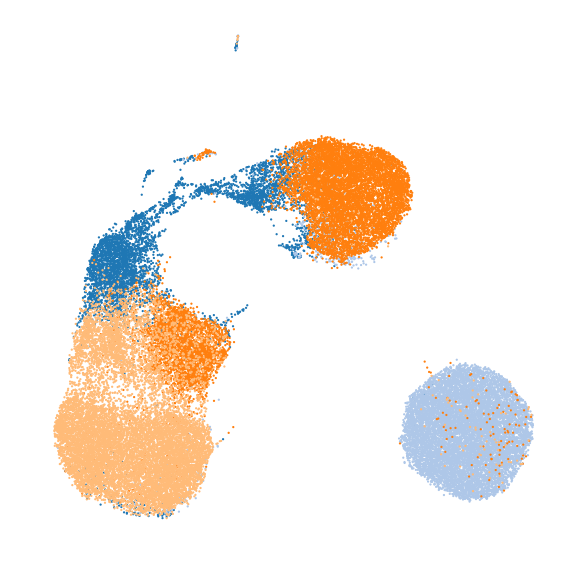

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(key_order):
    idx = scvi_KMeans_labels_pred==k
    ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none',s=5)
# plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_anot_kMeans.pdf", transparency=True)

In [56]:
scvi_DBSCAN_labels_pred = DBSCAN(eps=1.5, min_samples=30).fit_predict(latent)
scvi_DBSCAN_acc = unsupervised_clustering_accuracy(gene_dataset.labels.ravel(), scvi_DBSCAN_labels_pred, True)

In [57]:
np.unique(scvi_DBSCAN_labels_pred,return_counts=True)

(array([-1,  0]), array([13073, 29846]))

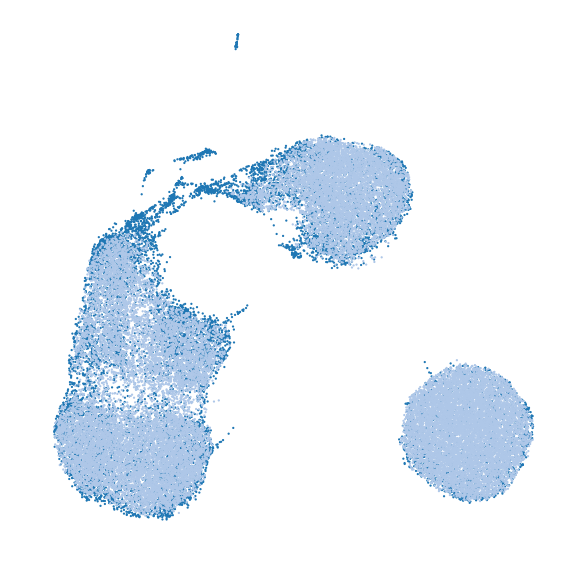

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(np.unique(scvi_DBSCAN_labels_pred)):
    idx = scvi_DBSCAN_labels_pred==k
    if np.sum(idx)>0:
        ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=np.unique(scvi_DBSCAN_labels_pred)[k],
                       edgecolors='none',s=5)
# plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_anot_DBSCAN.pdf", transparency=True)

In [59]:
scvi_DBSCAN_acc = unsupervised_clustering_accuracy(gene_dataset.labels.ravel(), scvi_DBSCAN_labels_pred, True)

In [60]:
scvi_DBSCAN_acc

0.20954990378984356

In [61]:
import phenograph
communities, graph, Q = phenograph.cluster(latent)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 12.781521320343018 seconds
Jaccard graph constructed in 8.644597291946411 seconds
Wrote graph to binary file in 3.269209861755371 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.706866
After 2 runs, maximum modularity is Q = 0.714644
After 3 runs, maximum modularity is Q = 0.716238
After 4 runs, maximum modularity is Q = 0.71859
After 5 runs, maximum modularity is Q = 0.721028
Louvain completed 25 runs in 67.76356530189514 seconds
PhenoGraph complete in 92.63272428512573 seconds


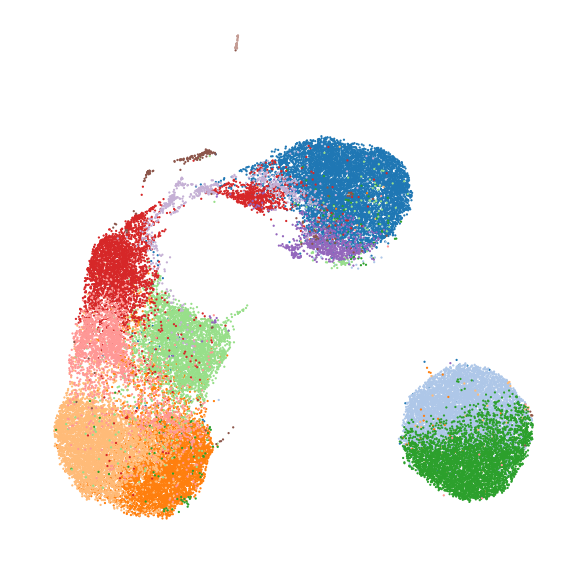

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(np.unique(communities)):
    idx = communities==k
    if np.sum(idx)>0:
        ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=np.unique(communities)[k],
                       edgecolors='none',s=5)
# plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_anot_phenograph.pdf", transparency=True)

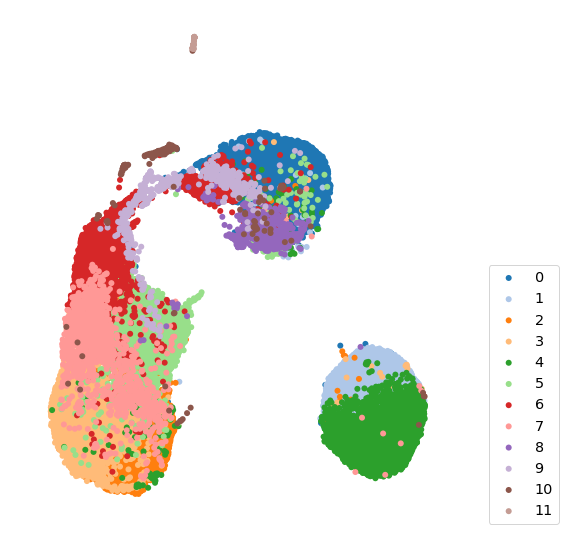

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))
for i,k in enumerate(np.unique(communities)):
    idx = communities==k
    if np.sum(idx)>0:
        ax.scatter(latent_u[idx, 0], latent_u[idx, 1], c=colors[i%20], label=np.unique(communities)[k],
                       edgecolors='none')
plt.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
plt.axis("off")
fig.tight_layout()
plt.savefig("figures/mild_anot_phenograph.legend.pdf", transparency=True)

In [64]:
scvi_pheno_acc = unsupervised_clustering_accuracy(gene_dataset.labels.ravel(), communities, True)

In [65]:
seurat_KNN_acc = np.mean(gene_dataset.labels.ravel()[unlabelled_idx]==seurat_pred)

In [66]:
scvi_KNN_acc = np.mean(gene_dataset.labels.ravel()[unlabelled_idx]==scvi_pred)

In [67]:
scanvi_acc = np.mean(all_y_pred.argmax(1) == labels)

In [68]:
[seurat_KMeans_acc, scvi_KMeans_acc,seurat_KNN_acc,scvi_KNN_acc, scvi_DBSCAN_acc, scvi_pheno_acc,scanvi_acc]

[0.7206464335249849,
 0.7588991780030497,
 0.7254617383365716,
 0.6835365996395046,
 0.20954990378984356,
 0.48380668858098413,
 0.9216197954285981]